In [6]:
import os
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt



In [7]:
def transform_ctdata(image,windowWidth, windowCenter, normal=False):
    minWindow = float(windowCenter) - 0.5*float(windowWidth)
    newImg = (image - minWindow) / float(windowWidth)
    newImg[newImg < 0] = 0
    newImg[newImg > 1] = 1
    if not normal:
        newImg = (newImg * 255).astype('uint8')
    return newImg

def clahe_equalized(imgs):
    assert(len(imgs.shape)==3)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(len(imgs)):
        imgs_equalized[i,:,:] = clahe.apply(np.array(imgs[i,:,:], dtype=np.uint8))
    return imgs_equalized
    
def plot(orginImage, transimage,originMask,demo, n):
    figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
    ax[0].imshow(orginImage[n,:,:],cmap='gray')
    ax[1].imshow(transimage[n,:,:],cmap='gray')
    ax[2].imshow(originMask[n,:,:],cmap='gray')
    ax[3].imshow(demo[n,:,:],cmap='gray')
    figure.tight_layout()
    figure.show()
    
def plot_2d(orginImage,originMask):
    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    ax[0].imshow(orginImage,cmap='gray',vmin=0,vmax=255)
    ax[1].imshow(originMask,cmap='gray',vmin=0,vmax=2)
    figure.tight_layout()
    figure.show()

In [8]:
# 训练集
ct_path = '../LITS2017/train/CT'
seg_path = '../LITS2017/train/seg'



outputImg_path = "data/liver/trainImage"
outputMask_path = "data/liver/trainMask"

# 验证集
# ct_path = '../LITS2017/valid/CT'
# seg_path = '../LITS2017/valid/seg'


# outputImg_path = "data/liver/validImage"
# outputMask_path = "data/liver/validMask"

# 测试集
# ct_path = '../LITS2017/test/CT'
# seg_path = '../LITS2017/test/seg'


# outputImg_path = "data/liver/testImage"
# outputMask_path = "data/liver/testMask"

  0%|                                                                                                                                                                                                                                                        | 0/104 [00:00<?, ?it/s]

(685, 512, 512)
(685, 512, 512)
cs 387 662 volume-100.nii
ct_crop.shape (275, 512, 512)
468 40.0


C:\Users\22335\AppData\Local\Temp\ipykernel_79516\1677565742.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
  0%|                                                                                                                                                                                                                                                        | 0/104 [00:04<?, ?it/s]

Done！


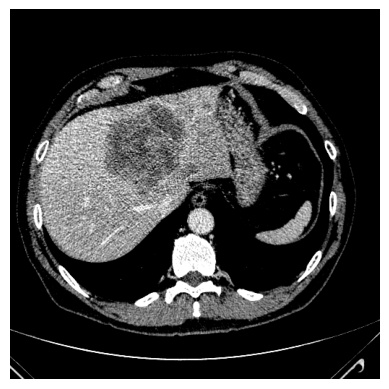

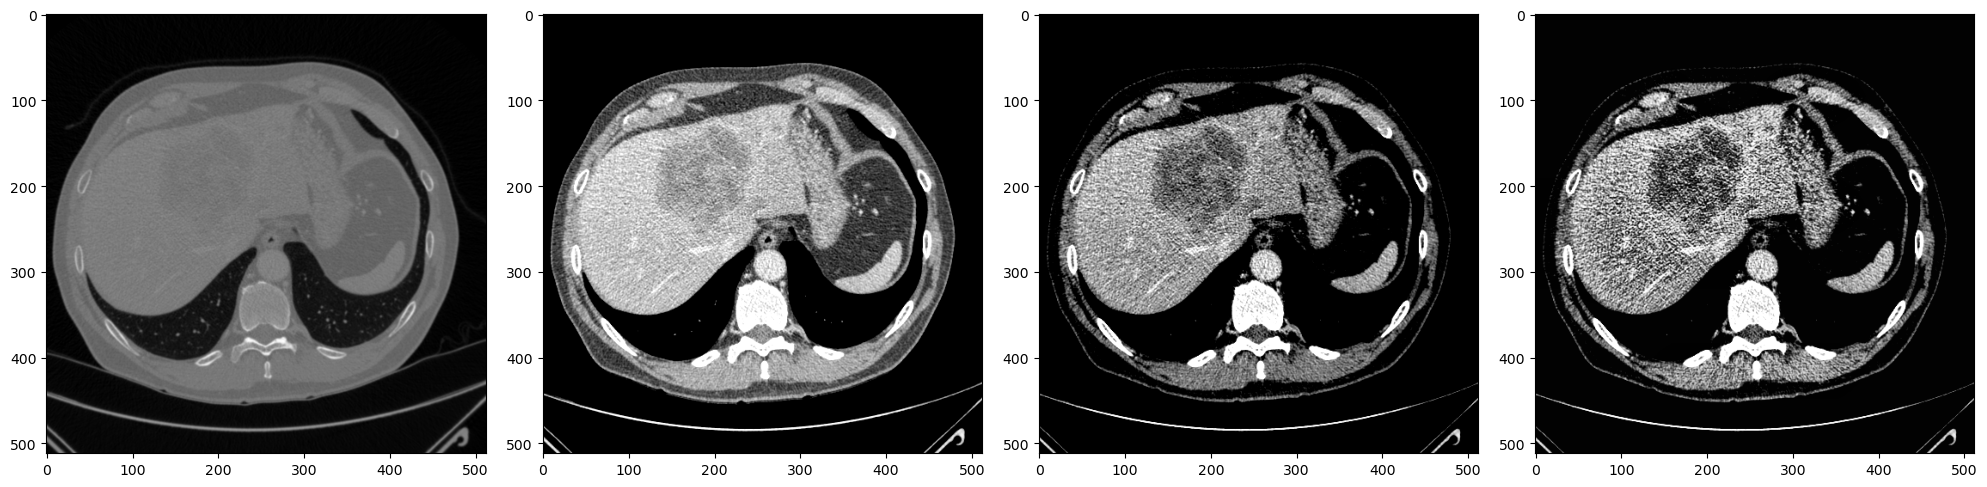

In [22]:
import PIL.Image as Image
for index, file in enumerate(tqdm(os.listdir(ct_path))):

    # 获取CT图像及Mask数据
    ct_src = sitk.ReadImage(os.path.join(ct_path, file), sitk.sitkInt16)
    mask = sitk.ReadImage(os.path.join(seg_path, file.replace('volume', 'segmentation')), sitk.sitkUInt8)
    # GetArrayFromImage()可用于将SimpleITK对象转换为ndarray
    ct_array = sitk.GetArrayFromImage(ct_src)
    mask_array = sitk.GetArrayFromImage(mask)
    
    print(ct_array.shape)
    print(mask_array.shape)

    # mask_array[mask_array == 1] = 0  # 肿瘤
    # mask_array[mask_array == 2] = 1
    
    
    # 阈值截取
#     ct_array[ct_array > 200] = 200
#     ct_array[ct_array < -200] = -200

#     ct_array = ct_array.astype(np.float32)
#     ct_array = ct_array / 200

    # 找到肝脏区域开始和结束的slice，并各向外扩张slice
    z = np.any(mask_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]

    print('cs',start_slice,end_slice,file)
    start_slice = max(0, start_slice)
    end_slice = min(mask_array.shape[0] - 1, end_slice)

    ct_crop = ct_array[start_slice:end_slice, :, :]
    mask_crop = mask_array[start_slice:end_slice, :, :]

    # #裁剪(偶数才行) 448*448
    # ct_crop = ct_crop[:,32:480,32:480]
    # mask_crop = mask_crop[:,32:480,32:480]

    print('ct_crop.shape',ct_crop.shape)
    
    seg_bg = mask_crop == 0
    seg_liver = mask_crop >= 1
    seg_tumor = mask_crop ==2

    ct_bg = ct_crop * seg_bg
    ct_liver = ct_crop * seg_liver
    ct_tumor = ct_crop * seg_tumor

    liver_min = ct_liver.min()
    liver_max = ct_liver.max()
    tumor_min = ct_tumor.min()
    tumor_max = ct_tumor.max()

    liver_wide = liver_max - liver_min
    liver_center = (liver_max + liver_min)/2
    
    tumor_wide = tumor_max - tumor_min
    tumor_center = (tumor_max + tumor_min)/2
    
    print(tumor_wide,tumor_center)


    ct = transform_ctdata(ct_crop,250,75)
    
    ct_cle = clahe_equalized(ct)

    ct1 = transform_ctdata(ct_crop, liver_wide, liver_center)
    
    ct2 = transform_ctdata(ct_crop, tumor_wide, tumor_center)
    
    ct3 = clahe_equalized(ct2)
    
    ct4 = ct3 / 255
    
    ct5 = 1 - ct4
    
    ct0 = ct_crop.copy()
    
    
    ct_crop[ct_crop > 200] = 200
    ct_crop[ct_crop < -200] = -200

    ct_crop = ct_crop.astype(np.float32)
    ct_crop = ct_crop / 200
    
    frame = 200
    np.save('before.npy', ct0[frame,:,:])
    np.save('after.npy',ct_crop[frame,:,:])
    
    plt.imshow(ct0[frame,:,:],cmap='gray')
    plt.axis('off')
    plt.savefig('before.jpg')
    
    plt.imshow(ct[frame,:,:],cmap='gray')
    plt.axis('off')
    plt.savefig('after.jpg')
    
    
    plot(ct0,ct_crop,ct,ct_cle,frame)

    
    # plot_2d(ct_liver[200,:,:],ct_tumor[200,:,:])
    break

    # 切片处理,并去掉没有病灶的切片
    if int(np.sum(mask_crop))!=0:
        for n_slice in range(mask_crop.shape[0]):
            maskImg = mask_crop[n_slice, :, :]
            if np.max(maskImg) != 2:
                continue
            ctImageArray = np.zeros((ct_crop.shape[1], ct_crop.shape[2], 3), np.float)
            ctImageArray[:, :, 0] = ct_crop[n_slice , :, :]
            ctImageArray[:, :, 1] = ct_crop[n_slice + 1, :, :]
            ctImageArray[:, :, 2] = ct_crop[n_slice + 2, :, :]

            imagepath = outputImg_path + "/" + str(index+1) + "_" + str(n_slice) + ".npy"
            maskpath = outputMask_path + "/" + str(index+1) + "_" + str(n_slice) + ".npy"

            np.save(imagepath, ctImageArray)  # (448，448,3) np.float dtype('float64')
            np.save(maskpath, maskImg)  # (448，448) dtype('uint8') 值为0 1 2
    else:
        continue
print("Done！")



# ct_array[ct_array > 200] = 200
# ct_array[ct_array < -200] = -200

# ct_array = ct_array.astype(np.float32)
# ct_array = ct_array / 200

# z = np.any(mask_array, axis=(1, 2))
# start_slice, end_slice = np.where(z)[0][[0, -1]]

# print('cs',start_slice,end_slice)
# start_slice = max(0, start_slice)
# end_slice = min(mask_array.shape[0] - 1, end_slice)

# ct_crop = ct_array[start_slice:end_slice, :, :]
# mask_crop = mask_array[start_slice:end_slice, :, :]

# print(ct_crop.shape)
# print(mask_crop.shape)

# maskImg = mask_crop[i, :, :]
            
# ctImageArray = np.zeros((ct_crop.shape[1], ct_crop.shape[2]), np.float)
# ctImageArray[:, :] = ct_crop[i , :, :]
# plot_2d(ctImageArray, maskImg)


# seg_bg = mask_array == 0
# seg_liver = mask_array >= 1
# seg_tumor = mask_array ==2

# ct_bg = ct_array * seg_bg
# ct_liver = ct_array * seg_liver
# ct_tumor = ct_array * seg_tumor

# liver_min = ct_liver.min()
# liver_max = ct_liver.max()
# tumor_min = ct_tumor.min()
# tumor_max = ct_tumor.max()

# liver_wide = liver_max - liver_min
# liver_center = (liver_max + liver_min)/2


# ct = transform_ctdata(ct_array,250,75)

# ct1 = transform_ctdata(ct_array, liver_wide, liver_center)
# print(ct[i,:,:].max())
# print(mask_array[i,:,:].max())
# plot(ct_array,ct_crop,mask_crop,i)










In [23]:
# 训练集
# ct_path = '../LITS2017/train/CT'
# seg_path = '../LITS2017/train/seg'
# png_path = './png/'

# outputImg_path = "data/tumor/trainImage"
# outputMask_path = "data/tumor/trainMask"

# 验证集
# ct_path = '../LITS2017/valid/CT'
# seg_path = '../LITS2017/valid/seg'
# png_path = './png/'

# outputImg_path = "data/tumor/validImage"
# outputMask_path = "data/tumor/validMask"

# 测试集
# ct_path = '../LITS2017/test/CT'
# seg_path = '../LITS2017/test/seg'
# png_path = './png/'

# outputImg_path = "data/tumor/testImage"
# outputMask_path = "data/tumor/testMask"

In [12]:
# 训练集
# ct_path = '../LITS2017/train/CT'
# seg_path = '../LITS2017/train/seg'
# png_path = './png/'

# outputImg_path = "data/liver/trainImage"
# outputMask_path = "data/liver//trainMask"

# 验证集
ct_path = '../LITS2017/valid/CT'
seg_path = '../LITS2017/valid/seg'
png_path = './png/'

outputImg_path = "data/liver/validImage"
outputMask_path = "data/liver/validMask"

# 测试集
# ct_path = '../LITS2017/test/CT'
# seg_path = '../LITS2017/test/seg'
# png_path = './png/'

# outputImg_path = "data/2d/liver/testImage"
# outputMask_path = "data/2d/liver/testMask"

In [15]:
if not os.path.exists(outputImg_path):
    os.makedirs(outputImg_path)
if not os.path.exists(outputMask_path):
    os.makedirs(outputMask_path)

def file_name_path(file_dir, dir=True, file=False):
    """
    get root path,sub_dirs,all_sub_files
    :param file_dir:
    :return: dir or file
    """
    for root, dirs, files in os.walk(file_dir):
        if len(dirs) and dir:
            print("sub_dirs:", dirs)
            return dirs
        if len(files) and file:
            print("files:", files)
            return files

def crop_ceter(img, croph, cropw):
    #for n_slice in range(img.shape[0]):
    height, width = img[0].shape
    starth = height//2 - (croph//2)
    startw = width//2 - (cropw//2)
    return img[:, starth:starth+croph, startw:startw+cropw]


for index, file in enumerate(tqdm(os.listdir(ct_path))):

    # 获取CT图像及Mask数据
    ct_src = sitk.ReadImage(os.path.join(ct_path, file), sitk.sitkInt16)
    mask = sitk.ReadImage(os.path.join(seg_path, file.replace('volume', 'segmentation')), sitk.sitkUInt8)
    # GetArrayFromImage()可用于将SimpleITK对象转换为ndarray
    ct_array = sitk.GetArrayFromImage(ct_src)
    mask_array = sitk.GetArrayFromImage(mask)
    
    
#     seg_bg = mask_array == 0
#     seg_liver = mask_array >= 1
#     seg_tumor = mask_array ==2

#     ct_bg = ct_array * seg_bg
#     ct_liver = ct_array * seg_liver
#     ct_tumor = ct_array * seg_tumor

    # liver_min = ct_liver.min()
    # liver_max = ct_liver.max()
    # tumor_min = ct_tumor.min()
    # tumor_max = ct_tumor.max()

    # liver_wide = liver_max - liver_min
    # liver_center = (liver_max + liver_min)/2
    
#     tumor_wide = tumor_max - tumor_min
#     tumor_center = (tumor_max + tumor_min)/2
    
#     ct = transform_ctdata(ct_array, tumor_wide, tumor_center,True)
    
#     ct = clahe_equalized(ct)

    # mask_array[mask_array == 1] = 0  # 肿瘤

    mask_array[mask_array > 0] = 1

    # 阈值截取
    ct_array[ct_array > 200] = 200
    ct_array[ct_array < -200] = -200

    ct_array = ct_array.astype(np.float32)
    ct_array = ct_array / 200

    # 找到肝脏区域开始和结束的slice，并各向外扩张slice
#     z = np.any(mask_array, axis=(1, 2))
#     start_slice, end_slice = np.where(z)[0][[0, -1]]

#     print('cs',start_slice,end_slice,file)
#     start_slice = max(0, start_slice - 1)
#     end_slice = min(mask_array.shape[0] - 1, end_slice + 2)

#     ct_crop = ct_array[start_slice:end_slice, :, :]
#     mask_crop = mask_array[start_slice+1:end_slice-1, :, :]
    z = np.any(mask_array, axis=(1, 2))
    start_slice, end_slice = np.where(z)[0][[0, -1]]

    print('cs',start_slice,end_slice,file)
    start_slice = max(0, start_slice)
    end_slice = min(mask_array.shape[0] - 1, end_slice)

    ct_crop = ct_array[start_slice:end_slice, :, :]
    mask_crop = mask_array[start_slice:end_slice, :, :]

    print('ct_crop.shape',ct_crop.shape)
    
    
    #裁剪(偶数才行) 448*448
    ct_crop = ct_crop[:,32:480,32:480]
    mask_crop = mask_crop[:,32:480,32:480]

    print('ct_crop.shape',ct_crop.shape)
    # 切片处理,并去掉没有病灶的切片
    if int(np.sum(mask_crop))!=0:
        for n_slice in range(mask_crop.shape[0]):
            maskImg = mask_crop[n_slice, :, :]
            # if np.max(maskImg) != 2:
            #     continue
            # ctImageArray = np.zeros((ct_crop.shape[1], ct_crop.shape[2], 3), np.float)
            # ctImageArray[:, :, 0] = ct_crop[n_slice , :, :]
            # ctImageArray[:, :, 1] = ct_crop[n_slice + 1, :, :]
            # ctImageArray[:, :, 2] = ct_crop[n_slice + 2, :, :]
            
            ctImageArray = np.zeros((ct_crop.shape[1], ct_crop.shape[2], 1), np.float)
            ctImageArray[:, :,0] = ct_crop[n_slice , :, :]

            imagepath = outputImg_path + "/" + str(index+1) + "_" + str(n_slice) + ".npy"
            maskpath = outputMask_path + "/" + str(index+1) + "_" + str(n_slice) + ".npy"

            np.save(imagepath, ctImageArray)  # (448，448,3) np.float dtype('float64')
            np.save(maskpath, maskImg)  # (448，448) dtype('uint8') 值为0 1 2
    else:
        continue
print("Done！")

  0%|                                                    | 0/27 [00:00<?, ?it/s]

cs 295 475 volume-10.nii
ct_crop.shape (180, 512, 512)
ct_crop.shape (180, 448, 448)


/home/jouiry/anaconda3/envs/medseg/lib/python3.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  4%|█▋                                          | 1/27 [00:02<01:14,  2.88s/it]

cs 260 434 volume-21.nii
ct_crop.shape (174, 512, 512)
ct_crop.shape (174, 448, 448)


  7%|███▎                                        | 2/27 [00:05<01:09,  2.79s/it]

cs 354 542 volume-18.nii
ct_crop.shape (188, 512, 512)
ct_crop.shape (188, 448, 448)


 11%|████▉                                       | 3/27 [00:10<01:25,  3.57s/it]

cs 341 572 volume-25.nii
ct_crop.shape (231, 512, 512)
ct_crop.shape (231, 448, 448)


 15%|██████▌                                     | 4/27 [00:13<01:20,  3.50s/it]

cs 265 453 volume-12.nii
ct_crop.shape (188, 512, 512)
ct_crop.shape (188, 448, 448)


 22%|█████████▊                                  | 6/27 [00:16<00:46,  2.23s/it]

cs 45 73 volume-0.nii
ct_crop.shape (28, 512, 512)
ct_crop.shape (28, 448, 448)
cs 354 547 volume-20.nii
ct_crop.shape (193, 512, 512)
ct_crop.shape (193, 448, 448)


 26%|███████████▍                                | 7/27 [00:19<00:48,  2.42s/it]

cs 272 438 volume-11.nii
ct_crop.shape (166, 512, 512)
ct_crop.shape (166, 448, 448)


 33%|██████████████▋                             | 9/27 [00:22<00:32,  1.80s/it]

cs 45 73 volume-1.nii
ct_crop.shape (28, 512, 512)
ct_crop.shape (28, 448, 448)
cs 332 510 volume-8.nii
ct_crop.shape (178, 512, 512)
ct_crop.shape (178, 448, 448)


 37%|███████████████▉                           | 10/27 [00:24<00:34,  2.06s/it]

cs 272 413 volume-13.nii
ct_crop.shape (141, 512, 512)
ct_crop.shape (141, 448, 448)


 41%|█████████████████▌                         | 11/27 [00:27<00:37,  2.35s/it]

cs 343 515 volume-9.nii
ct_crop.shape (172, 512, 512)
ct_crop.shape (172, 448, 448)


 44%|███████████████████                        | 12/27 [00:30<00:36,  2.43s/it]

cs 324 511 volume-19.nii
ct_crop.shape (187, 512, 512)
ct_crop.shape (187, 448, 448)


 48%|████████████████████▋                      | 13/27 [00:33<00:35,  2.52s/it]

cs 141 258 volume-24.nii
ct_crop.shape (117, 512, 512)
ct_crop.shape (117, 448, 448)


 52%|██████████████████████▎                    | 14/27 [00:35<00:31,  2.46s/it]

cs 324 500 volume-7.nii
ct_crop.shape (176, 512, 512)
ct_crop.shape (176, 448, 448)


 56%|███████████████████████▉                   | 15/27 [00:38<00:30,  2.53s/it]

cs 334 472 volume-2.nii
ct_crop.shape (138, 512, 512)
ct_crop.shape (138, 448, 448)


 59%|█████████████████████████▍                 | 16/27 [00:40<00:27,  2.47s/it]

cs 267 453 volume-16.nii
ct_crop.shape (186, 512, 512)
ct_crop.shape (186, 448, 448)


 63%|███████████████████████████                | 17/27 [00:44<00:28,  2.82s/it]

cs 328 525 volume-17.nii
ct_crop.shape (197, 512, 512)
ct_crop.shape (197, 448, 448)


 67%|████████████████████████████▋              | 18/27 [00:48<00:29,  3.24s/it]

cs 103 148 volume-22.nii
ct_crop.shape (45, 512, 512)
ct_crop.shape (45, 448, 448)


 70%|██████████████████████████████▎            | 19/27 [00:49<00:20,  2.57s/it]

cs 305 490 volume-6.nii
ct_crop.shape (185, 512, 512)
ct_crop.shape (185, 448, 448)


 74%|███████████████████████████████▊           | 20/27 [00:52<00:18,  2.63s/it]

cs 260 398 volume-14.nii
ct_crop.shape (138, 512, 512)
ct_crop.shape (138, 448, 448)


 78%|█████████████████████████████████▍         | 21/27 [00:56<00:18,  3.11s/it]

cs 312 487 volume-5.nii
ct_crop.shape (175, 512, 512)
ct_crop.shape (175, 448, 448)


 81%|███████████████████████████████████        | 22/27 [00:59<00:15,  3.06s/it]

cs 262 377 volume-23.nii
ct_crop.shape (115, 512, 512)
ct_crop.shape (115, 448, 448)


 85%|████████████████████████████████████▋      | 23/27 [01:01<00:10,  2.71s/it]

cs 347 596 volume-4.nii
ct_crop.shape (249, 512, 512)
ct_crop.shape (249, 448, 448)


 89%|██████████████████████████████████████▏    | 24/27 [01:05<00:09,  3.30s/it]

cs 303 471 volume-3.nii
ct_crop.shape (168, 512, 512)
ct_crop.shape (168, 448, 448)


 93%|███████████████████████████████████████▊   | 25/27 [01:08<00:06,  3.20s/it]

cs 255 446 volume-26.nii
ct_crop.shape (191, 512, 512)
ct_crop.shape (191, 448, 448)


 96%|█████████████████████████████████████████▍ | 26/27 [01:12<00:03,  3.27s/it]

cs 240 372 volume-15.nii
ct_crop.shape (132, 512, 512)
ct_crop.shape (132, 448, 448)


100%|███████████████████████████████████████████| 27/27 [01:14<00:00,  2.77s/it]

Done！


In [ ]:
# 切片为3

if not os.path.exists(outputImg_path):
    os.makedirs(outputImg_path)
if not os.path.exists(outputMask_path):
    os.makedirs(outputMask_path)

def file_name_path(file_dir, dir=True, file=False):
    """
    get root path,sub_dirs,all_sub_files
    :param file_dir:
    :return: dir or file
    """
    for root, dirs, files in os.walk(file_dir):
        if len(dirs) and dir:
            print("sub_dirs:", dirs)
            return dirs
        if len(files) and file:
            print("files:", files)
            return files

def crop_ceter(img, croph, cropw):
    #for n_slice in range(img.shape[0]):
    height, width = img[0].shape
    starth = height//2 - (croph//2)
    startw = width//2 - (cropw//2)
    return img[:, starth:starth+croph, startw:startw+cropw]


for index, file in enumerate(tqdm(os.listdir(ct_path))):

    # 获取CT图像及Mask数据
    ct_src = sitk.ReadImage(os.path.join(ct_path, file), sitk.sitkInt16)
    mask = sitk.ReadImage(os.path.join(seg_path, file.replace('volume', 'segmentation')), sitk.sitkUInt8)
    # GetArrayFromImage()可用于将SimpleITK对象转换为ndarray
    ct_array = sitk.GetArrayFromImage(ct_src)
    mask_array = sitk.GetArrayFromImage(mask)

    # mask_array[mask_array == 1] = 0  # 肿瘤
    mask_array[mask_array == 2] = 1

    # 阈值截取
    ct_array[ct_array > 200] = 200
    ct_array[ct_array < -200] = -200

    ct_array = ct_array.astype(np.float32)
    ct_array = ct_array / 200

    # 找到肝脏区域开始和结束的slice，并各向外扩张slice
#     z = np.any(mask_array, axis=(1, 2))
#     start_slice, end_slice = np.where(z)[0][[0, -1]]

#     print('cs',start_slice,end_slice,file)
#     start_slice = max(0, start_slice - 1)
#     end_slice = min(mask_array.shape[0] - 1, end_slice + 2)

#     ct_crop = ct_array[start_slice:end_slice, :, :]
#     mask_crop = mask_array[start_slice+1:end_slice-1, :, :]

    #裁剪(偶数才行) 448*448
    ct_crop = ct_crop[:,32:480,32:480]
    mask_crop = mask_crop[:,32:480,32:480]

    print('ct_crop.shape',ct_crop.shape)

    # 切片处理,并去掉没有病灶的切片
    if int(np.sum(mask_crop))!=0:
        for n_slice in range(mask_crop.shape[0]):
            maskImg = mask_crop[n_slice, :, :]
            if np.max(maskImg) != 2:
                continue
            ctImageArray = np.zeros((ct_crop.shape[1], ct_crop.shape[2], 3), np.float)
            ctImageArray[:, :, 0] = ct_crop[n_slice , :, :]
            ctImageArray[:, :, 1] = ct_crop[n_slice + 1, :, :]
            ctImageArray[:, :, 2] = ct_crop[n_slice + 2, :, :]

            imagepath = outputImg_path + "/" + str(index+1) + "_" + str(n_slice) + ".npy"
            maskpath = outputMask_path + "/" + str(index+1) + "_" + str(n_slice) + ".npy"

            np.save(imagepath, ctImageArray)  # (448，448,3) np.float dtype('float64')
            np.save(maskpath, maskImg)  # (448，448) dtype('uint8') 值为0 1 2
    else:
        continue
print("Done！")